In [1]:
!pip install --quiet --no-cache-dir h3ronpy

In [30]:
import os

import geopandas as gpd
import h3
import pandas as pd
import rasterio as rio
import rasterio.plot
from h3ronpy import raster
from rasterstats import gen_point_query
from shapely.geometry import Point, Polygon, box, mapping

In [4]:
test_raster = (
    "../../data/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m.tif"
)

test_area = (-10, 40, 0, 50)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


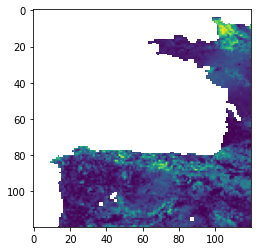

,h3index,value,geometry
0,595480473807880191,0.090241,"POLYGON ((-8.18582 43.32105, -8.48380 43.22372..."
1,595481126642909183,0.229099,"POLYGON ((-6.36596 42.03914, -6.65737 41.94526..."
2,595480774455590911,0.339002,"POLYGON ((-2.66216 42.69643, -2.95213 42.61422..."
3,595480963434151935,0.011052,"POLYGON ((-5.16229 42.64607, -5.45505 42.55655..."
4,595485885466673151,0.344788,"POLYGON ((-1.59934 42.54400, -1.88714 42.46461..."


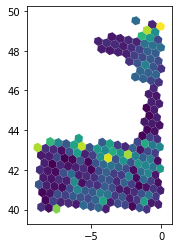

In [5]:
with rio.open(test_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)
    print(src.profile)
    rio.plot.show(src.read(window=window, masked=True))
    gdf = raster.raster_to_geodataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=4,
        nodata_value=src.profile["nodata"],
        compacted=False,
    )

gdf.plot("value")
# gdf['h3index'] = gdf['h3index'].apply(hex)
gdf.head()

,h3index,value
0,595484974933606399,0.090976
3,595480800225394687,0.180818
6,594904226635710463,0.066184
7,595480774455590911,0.339002
8,594902405569576959,0.138503


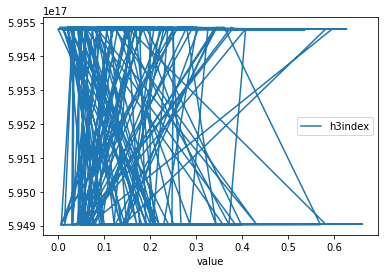

In [6]:
geom = box(*test_area)
idx = [h for h in h3.polyfill(mapping(geom), 4, geo_json_conformant=True)]
pts = [Point(h3.h3_to_geo(h)[::-1]) for h in idx]
idx_int = [int(h, 16) for h in idx]
geoms = h3.h3_set_to_multi_polygon(idx, geo_json=True)

df = pd.DataFrame(
    {"h3index": idx_int, "value": gen_point_query(pts, test_raster, interpolate="nearest")}
)
df = df.dropna()
df.plot("value")
df.head()

In [7]:
j = gdf.set_index("h3index").join(df.set_index("h3index"), rsuffix="t")
j

,value,geometry,valuet
h3index,,,
595480473807880191,0.090241,"POLYGON ((-8.18582 43.32105, -8.48380 43.22372...",0.090241
595481126642909183,0.229099,"POLYGON ((-6.36596 42.03914, -6.65737 41.94526...",0.229099
595480774455590911,0.339002,"POLYGON ((-2.66216 42.69643, -2.95213 42.61422...",0.339002
595480963434151935,0.011052,"POLYGON ((-5.16229 42.64607, -5.45505 42.55655...",0.011052
595485885466673151,0.344788,"POLYGON ((-1.59934 42.54400, -1.88714 42.46461...",0.344788
...,...,...,...
594902543008530431,0.123677,"POLYGON ((-3.06825 43.48261, -3.36206 43.40047...",0.123677
595480198929973247,0.076786,"POLYGON ((-7.14827 42.48653, -7.44212 42.39102...",0.076786
594902671857549311,0.032122,"POLYGON ((-0.42802 44.17761, -0.72084 44.10430...",0.032122


In [135]:
%%timeit
pd.DataFrame(
    {"h3index": idx_int, "value": gen_point_query(pts, test_raster, interpolate="nearest")}
)

2.98 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [137]:
%%timeit
with rio.open(test_raster) as src:
    raster.to_dataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=4,
        nodata_value=src.profile["nodata"],
        compacted=False,
    )

8.04 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
dfs = []
with rio.open(test_raster) as src:
    for ji, window in src.block_windows():
        transform = rio.windows.transform(window, src.transform)
        arr = src.read(1, window=window)

        df = h3ronpy.raster.raster_to_geodataframe(
            arr, transform, 4, nodata_value=src.profile["nodata"], compacted=False
        )
        dfs.append(df)

In [147]:
l = [i for df in dfs for i in df["h3index"]]
print(len(l))
print(len(set(l)))

72314
72314


<AxesSubplot:>

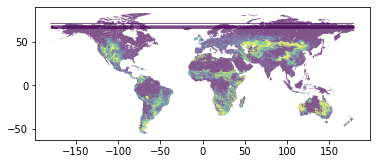

In [150]:
pd.concat(dfs).plot("value")

In [23]:
from math import ceil

BLOCKSIZE = 512


def gen_raster_h3(raster_list, h3_res):
    """Convert a list of identically formatted rasters to H3

    A function for efficiently turning a set of rasters into an H3 table.

    Takes a list of 1-band rasters with identical projection/transform.
    Reads each raster in blocks, and converts to h3 (nearest to centroid).
    Yields a dataframe with an h3index and one column for each raster's value.

    Args:
        raster_list: list of paths to rasters
        h3_res: h3 resolution to use for resampling

    Yields:
        A Pandas dataframe for each raster block (usu. 512x512) with an
        h3index and one column for each raster's value.
    """
    readers = [rio.open(r) for r in raster_list]
    names = [os.path.splitext(os.path.basename(r))[0].lower() for r in raster_list]

    base = readers[0]
    for j in range(ceil(base.height / BLOCKSIZE)):
        for i in range(ceil(base.width / BLOCKSIZE)):
            window = rio.windows.Window(i * BLOCKSIZE, j * BLOCKSIZE, BLOCKSIZE, BLOCKSIZE)
            w_transform = rio.windows.transform(window, base.transform)
            dfs = []
            for src in readers:
                if src.transform != base.transform:
                    raise ValueError("Transforms do not match")
                arr = src.read(1, window=window)
                _df = raster.raster_to_dataframe(
                    arr, w_transform, h3_res, nodata_value=src.profile["nodata"], compacted=False
                )
                dfs.append(_df.set_index("h3index")["value"])
            df = pd.concat(dfs, axis=1)
            print(f"Reading block {j}, {i}: h3index count {len(df)}")
            if len(df):
                df.columns = names
                # cast h3index from int64 to hex string
                yield df
    for src in readers:
        src.close()

In [32]:
test_list = [
    "../../data/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m.tif",
    "../../data/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Cropland2000_5m.tif",
]
test_dir = "../../data/seed/mapspam/spam2017v2r1_ssa_prod"
test_list2 = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

h3grid = pd.concat(list(gen_raster_h3(test_list2, 4)))
h3grid = gpd.GeoDataFrame(
    h3grid, geometry=[Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in h3grid.index]
)
h3grid.plot()

FileNotFoundError: [Errno 2] No such file or directory: '../../seed/mapspam/spam2017v2r1_ssa_prod'